# NB02: Co-occurrence Analysis

For each organism, compute the phi coefficient (co-occurrence) between co-fit gene
pairs and compare to prevalence-matched random pairs.

**Runs locally** — no Spark needed. Requires extracted data from NB01.

### Key steps
1. Load genome × cluster presence matrix
2. Map cofit pairs to cluster pairs via `fb_pangenome_link.tsv`
3. Compute phi coefficient for each cofit cluster pair
4. Generate prevalence-matched random pairs
5. Label pairs as adjacent or distant
6. Save per-organism results

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from pathlib import Path
from itertools import combinations
import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)

DATA_DIR = Path('../data')
CONS_DIR = Path('../../conservation_vs_fitness/data')

# Load shared data
link = pd.read_csv(CONS_DIR / 'fb_pangenome_link.tsv', sep='\t')
link = link[link['orgId'] != 'Dyella79']
link['locusId'] = link['locusId'].astype(str)

# Target organisms
TARGET_ORGANISMS = [
    'Koxy', 'Btheta', 'Smeli', 'RalstoniaUW163', 'Putida',
    'SyringaeB728a', 'Korea', 'RalstoniaGMI1000', 'Phaeo',
    'Ddia6719', 'pseudo3_N2E3',
]

# Only process organisms with extracted data
available = [org for org in TARGET_ORGANISMS
             if (DATA_DIR / 'genome_cluster_matrices' / f'{org}_presence.tsv').exists()]
print(f"Organisms with data: {len(available)}/{len(TARGET_ORGANISMS)}")
print(f"Available: {available}")

Organisms with data: 11/11
Available: ['Koxy', 'Btheta', 'Smeli', 'RalstoniaUW163', 'Putida', 'SyringaeB728a', 'Korea', 'RalstoniaGMI1000', 'Phaeo', 'Ddia6719', 'pseudo3_N2E3']


## Helper Functions

In [2]:
def compute_phi(vec_a, vec_b):
    """Compute phi coefficient between two binary vectors.
    
    Phi = Pearson correlation of two binary variables.
    Returns NaN if either vector has zero variance.
    """
    if vec_a.std() == 0 or vec_b.std() == 0:
        return np.nan
    return np.corrcoef(vec_a, vec_b)[0, 1]


def compute_prevalence(matrix):
    """Compute prevalence (fraction of genomes) for each cluster."""
    return matrix.sum(axis=0) / matrix.shape[0]


def get_gene_order(coords_df):
    """Assign ordinal positions to genes on each scaffold.
    
    Returns dict: locusId -> (scaffoldId, ordinal_position)
    """
    coords_df = coords_df.sort_values(['scaffoldId', 'begin'])
    coords_df['gene_order'] = coords_df.groupby('scaffoldId').cumcount()
    return dict(zip(
        coords_df['locusId'].astype(str),
        zip(coords_df['scaffoldId'], coords_df['gene_order'])
    ))


def are_adjacent(locus1, locus2, gene_order, max_distance=5):
    """Check if two genes are within max_distance loci on the same scaffold."""
    pos1 = gene_order.get(str(locus1))
    pos2 = gene_order.get(str(locus2))
    if pos1 is None or pos2 is None:
        return False
    if pos1[0] != pos2[0]:  # different scaffolds
        return False
    return abs(pos1[1] - pos2[1]) <= max_distance


def generate_random_pairs(prevalence, n_pairs, target_prev1, target_prev2,
                          tolerance=0.05, rng=None):
    """Generate random cluster pairs matched by individual prevalences.
    
    For each cofit pair with prevalences (p1, p2), sample one random cluster
    near p1 and one near p2 independently. This avoids the bias of matching
    on mean prevalence, which creates artificially similar-prevalence pairs.
    
    Returns list of (cluster1, cluster2) tuples.
    """
    if rng is None:
        rng = np.random.default_rng(42)
    
    clusters = prevalence.index.values
    prev_vals = prevalence.values
    
    # Find candidates matching each target prevalence independently
    cand1 = clusters[
        (prev_vals >= max(0, target_prev1 - tolerance)) &
        (prev_vals <= min(1, target_prev1 + tolerance))
    ]
    cand2 = clusters[
        (prev_vals >= max(0, target_prev2 - tolerance)) &
        (prev_vals <= min(1, target_prev2 + tolerance))
    ]
    
    if len(cand1) == 0 or len(cand2) == 0:
        return []
    
    pairs = []
    attempts = 0
    max_attempts = n_pairs * 10
    while len(pairs) < n_pairs and attempts < max_attempts:
        c1 = cand1[rng.integers(len(cand1))]
        c2 = cand2[rng.integers(len(cand2))]
        if c1 != c2:
            pairs.append((c1, c2))
        attempts += 1
    
    return pairs

## Per-Organism Co-occurrence Analysis

In [3]:
rng = np.random.default_rng(42)
N_RANDOM = 10  # random pairs per cofit pair

all_results = []

for orgId in available:
    result_path = DATA_DIR / f'{orgId}_phi_results.tsv'
    if result_path.exists() and result_path.stat().st_size > 0:
        cached = pd.read_csv(result_path, sep='\t', dtype={'locusId1': str, 'locusId2': str})
        all_results.append(cached)
        n_cofit = (cached['is_cofit'] == True).sum()
        n_random = (cached['is_cofit'] == False).sum()
        print(f"[{orgId}] Cached: {n_cofit:,} cofit + {n_random:,} random pairs")
        continue

    print(f"\n{'='*60}")
    print(f"Processing {orgId}")
    print(f"{'='*60}")

    # 1. Load presence matrix
    matrix = pd.read_csv(
        DATA_DIR / 'genome_cluster_matrices' / f'{orgId}_presence.tsv',
        sep='\t', index_col=0
    )
    matrix_np = matrix.values.astype(np.int8)
    cluster_cols = matrix.columns.values
    cluster_idx = {c: i for i, c in enumerate(cluster_cols)}
    print(f"  Matrix: {matrix_np.shape[0]} genomes x {matrix_np.shape[1]} clusters")

    # 2. Compute prevalence
    prevalence = pd.Series(matrix_np.sum(axis=0) / matrix_np.shape[0], index=cluster_cols)
    print(f"  Prevalence range: {prevalence.min():.3f} - {prevalence.max():.3f}")
    print(f"  Clusters with >0% prevalence: {(prevalence > 0).sum()}")

    # 3. Load cofit pairs and map to clusters
    cofit = pd.read_csv(DATA_DIR / 'cofit' / f'{orgId}_cofit.tsv', sep='\t')
    cofit['locusId'] = cofit['locusId'].astype(str)
    cofit['hitId'] = cofit['hitId'].astype(str)

    org_link = link[link['orgId'] == orgId][['locusId', 'gene_cluster_id']].copy()
    org_link['locusId'] = org_link['locusId'].astype(str)
    locus_to_cluster = dict(zip(org_link['locusId'], org_link['gene_cluster_id']))

    # Map cofit pairs to cluster pairs
    cofit['cluster1'] = cofit['locusId'].map(locus_to_cluster)
    cofit['cluster2'] = cofit['hitId'].map(locus_to_cluster)
    cofit_mapped = cofit.dropna(subset=['cluster1', 'cluster2'])

    # Filter to clusters present in the matrix
    cofit_mapped = cofit_mapped[
        cofit_mapped['cluster1'].isin(cluster_idx) &
        cofit_mapped['cluster2'].isin(cluster_idx)
    ]

    # Remove self-pairs and deduplicate (vectorized)
    cofit_mapped = cofit_mapped[cofit_mapped['cluster1'] != cofit_mapped['cluster2']]
    pair_arr = np.sort(cofit_mapped[['cluster1', 'cluster2']].values, axis=1)
    cofit_mapped = cofit_mapped.copy()
    cofit_mapped['pair_key'] = [f"{a}_{b}" for a, b in pair_arr]
    cofit_unique = cofit_mapped.drop_duplicates('pair_key')
    print(f"  Cofit pairs mapped to clusters: {len(cofit_unique):,}")

    if len(cofit_unique) == 0:
        print(f"  WARNING: No mappable cofit pairs for {orgId}, skipping")
        continue

    # 4. Load gene coordinates for adjacency
    coords_path = DATA_DIR / 'gene_coords' / f'{orgId}_coords.tsv'
    gene_order = {}
    if coords_path.exists():
        coords = pd.read_csv(coords_path, sep='\t')
        gene_order = get_gene_order(coords)

    # 5. Compute phi for cofit pairs
    results = []
    for _, row in cofit_unique.iterrows():
        c1, c2 = row['cluster1'], row['cluster2']
        i1, i2 = cluster_idx[c1], cluster_idx[c2]

        phi = compute_phi(matrix_np[:, i1], matrix_np[:, i2])
        p1 = prevalence[c1]
        p2 = prevalence[c2]
        mean_prev = (p1 + p2) / 2

        adj = are_adjacent(row['locusId'], row['hitId'], gene_order)

        results.append({
            'orgId': orgId,
            'locusId1': row['locusId'],
            'locusId2': row['hitId'],
            'cluster1': c1,
            'cluster2': c2,
            'cofit_score': row['cofit'],
            'cofit_rank': row['rank'],
            'phi': phi,
            'prev1': p1,
            'prev2': p2,
            'mean_prev': mean_prev,
            'prev_diff': abs(p1 - p2),
            'adjacent': adj,
            'is_cofit': True,
        })

    # 6. Generate matched random pairs -- match prev1 and prev2 independently
    random_results = []
    for r in results:
        rand_pairs = generate_random_pairs(
            prevalence, N_RANDOM, r['prev1'], r['prev2'],
            tolerance=0.05, rng=rng
        )
        for c1, c2 in rand_pairs:
            i1, i2 = cluster_idx[c1], cluster_idx[c2]
            phi = compute_phi(matrix_np[:, i1], matrix_np[:, i2])
            p1 = prevalence[c1]
            p2 = prevalence[c2]
            random_results.append({
                'orgId': orgId,
                'locusId1': '',
                'locusId2': '',
                'cluster1': c1,
                'cluster2': c2,
                'cofit_score': np.nan,
                'cofit_rank': np.nan,
                'phi': phi,
                'prev1': p1,
                'prev2': p2,
                'mean_prev': (p1 + p2) / 2,
                'prev_diff': abs(p1 - p2),
                'adjacent': False,
                'is_cofit': False,
            })

    org_results = pd.DataFrame(results + random_results)
    org_results.to_csv(result_path, sep='\t', index=False)
    all_results.append(org_results)

    n_cofit = len(results)
    n_random = len(random_results)
    cofit_phi = org_results[org_results['is_cofit']]['phi'].dropna()
    random_phi = org_results[~org_results['is_cofit']]['phi'].dropna()

    print(f"  Results: {n_cofit:,} cofit + {n_random:,} random pairs")
    print(f"  Cofit phi:  mean={cofit_phi.mean():.4f}, median={cofit_phi.median():.4f}")
    print(f"  Random phi: mean={random_phi.mean():.4f}, median={random_phi.median():.4f}")
    if len(cofit_phi) > 0 and len(random_phi) > 0:
        u_stat, u_pval = stats.mannwhitneyu(cofit_phi, random_phi, alternative='two-sided')
        direction = "cofit > random" if cofit_phi.mean() > random_phi.mean() else "random > cofit"
        print(f"  Mann-Whitney U (two-sided): U={u_stat:.0f}, p={u_pval:.2e} ({direction})")


Processing Koxy
  Matrix: 399 genomes x 4942 clusters
  Prevalence range: 0.003 - 1.000
  Clusters with >0% prevalence: 4942


  Cofit pairs mapped to clusters: 255,986


  Results: 255,986 cofit + 2,559,860 random pairs
  Cofit phi:  mean=0.0410, median=-0.0036
  Random phi: mean=0.0378, median=-0.0036


  Mann-Whitney U (two-sided): U=129434018734, p=3.30e-02 (cofit > random)

Processing Btheta


  Matrix: 287 genomes x 4649 clusters
  Prevalence range: 0.003 - 1.000
  Clusters with >0% prevalence: 4649


  Cofit pairs mapped to clusters: 261,346


  Results: 261,346 cofit + 2,613,460 random pairs
  Cofit phi:  mean=0.0673, median=0.0224
  Random phi: mean=0.0668, median=0.0241


  Mann-Whitney U (two-sided): U=293378117738, p=1.02e-06 (cofit > random)

Processing Smeli
  Matrix: 241 genomes x 6004 clusters
  Prevalence range: 0.004 - 1.000
  Clusters with >0% prevalence: 6004


  Cofit pairs mapped to clusters: 363,500


  Results: 363,500 cofit + 3,635,000 random pairs
  Cofit phi:  mean=0.0286, median=-0.0072
  Random phi: mean=0.0263, median=-0.0072


  Mann-Whitney U (two-sided): U=265007627824, p=9.55e-18 (cofit > random)

Processing RalstoniaUW163
  Matrix: 141 genomes x 4413 clusters
  Prevalence range: 0.007 - 1.000
  Clusters with >0% prevalence: 4413
  Cofit pairs mapped to clusters: 0

Processing Putida


  Matrix: 128 genomes x 5409 clusters
  Prevalence range: 0.008 - 1.000
  Clusters with >0% prevalence: 5409


  Cofit pairs mapped to clusters: 321,175


  Results: 321,175 cofit + 3,211,750 random pairs
  Cofit phi:  mean=0.1708, median=0.0476
  Random phi: mean=0.1709, median=0.0476


  Mann-Whitney U (two-sided): U=210866393972, p=4.14e-01 (random > cofit)

Processing SyringaeB728a
  Matrix: 126 genomes x 4999 clusters
  Prevalence range: 0.008 - 1.000
  Clusters with >0% prevalence: 4999


  Cofit pairs mapped to clusters: 242,609


  Results: 242,609 cofit + 2,426,090 random pairs
  Cofit phi:  mean=0.0485, median=-0.0114
  Random phi: mean=0.0428, median=-0.0114
  Mann-Whitney U (two-sided): U=80214020069, p=2.85e-04 (cofit > random)

Processing Korea


  Matrix: 72 genomes x 4075 clusters
  Prevalence range: 0.014 - 1.000
  Clusters with >0% prevalence: 4075


  Cofit pairs mapped to clusters: 166,601


  Results: 166,601 cofit + 1,666,010 random pairs
  Cofit phi:  mean=0.4474, median=0.2584
  Random phi: mean=0.4888, median=0.8597
  Mann-Whitney U (two-sided): U=283495942, p=2.14e-06 (random > cofit)

Processing RalstoniaGMI1000
  Matrix: 70 genomes x 4723 clusters
  Prevalence range: 0.014 - 1.000
  Clusters with >0% prevalence: 4723
  Cofit pairs mapped to clusters: 0

Processing Phaeo
  Matrix: 43 genomes x 3790 clusters
  Prevalence range: 0.023 - 1.000
  Clusters with >0% prevalence: 3790


  Cofit pairs mapped to clusters: 143,332


  Results: 143,332 cofit + 1,433,320 random pairs
  Cofit phi:  mean=0.2307, median=0.0605
  Random phi: mean=0.2220, median=0.0605
  Mann-Whitney U (two-sided): U=980843922, p=6.54e-04 (cofit > random)

Processing Ddia6719
  Matrix: 66 genomes x 4694 clusters
  Prevalence range: 0.015 - 1.000
  Clusters with >0% prevalence: 4694


  Cofit pairs mapped to clusters: 159,687


  Results: 159,687 cofit + 1,596,870 random pairs
  Cofit phi:  mean=0.1817, median=0.0355
  Random phi: mean=0.0891, median=0.0154
  Mann-Whitney U (two-sided): U=1869613144, p=0.00e+00 (cofit > random)

Processing pseudo3_N2E3
  Matrix: 40 genomes x 5513 clusters
  Prevalence range: 0.025 - 1.000
  Clusters with >0% prevalence: 5513


  Cofit pairs mapped to clusters: 339,255


  Results: 339,255 cofit + 3,392,550 random pairs
  Cofit phi:  mean=0.4582, median=0.4804
  Random phi: mean=0.4325, median=0.4804
  Mann-Whitney U (two-sided): U=5545059182, p=6.57e-16 (cofit > random)


## Combine All Results

In [4]:
if all_results:
    combined = pd.concat(all_results, ignore_index=True)
    combined.to_csv(DATA_DIR / 'all_phi_results.tsv', sep='\t', index=False)

    print(f"Combined results: {len(combined):,} total pairs")
    print(f"  Cofit pairs: {combined['is_cofit'].sum():,}")
    print(f"  Random pairs: {(~combined['is_cofit']).sum():,}")
    print(f"  Organisms: {combined['orgId'].nunique()}")

    # Per-organism summary
    summary = []
    for orgId in combined['orgId'].unique():
        org = combined[combined['orgId'] == orgId]
        cofit_phi = org[org['is_cofit']]['phi'].dropna()
        random_phi = org[~org['is_cofit']]['phi'].dropna()

        effect = cofit_phi.mean() - random_phi.mean() if len(random_phi) > 0 else np.nan
        if len(cofit_phi) > 0 and len(random_phi) > 0:
            _, pval = stats.mannwhitneyu(cofit_phi, random_phi, alternative='two-sided')
        else:
            pval = np.nan

        n_adj = org[org['is_cofit'] & org['adjacent']].shape[0]
        pct_adj = n_adj / max(1, org['is_cofit'].sum()) * 100

        summary.append({
            'orgId': orgId,
            'n_cofit': len(cofit_phi),
            'n_random': len(random_phi),
            'mean_phi_cofit': cofit_phi.mean(),
            'mean_phi_random': random_phi.mean(),
            'delta_phi': effect,
            'pval': pval,
            'pct_adjacent': pct_adj,
        })

    summary_df = pd.DataFrame(summary)
    summary_df.to_csv(DATA_DIR / 'organism_summary.tsv', sep='\t', index=False)
    print("\n=== PER-ORGANISM SUMMARY ===")
    print(summary_df.to_string(index=False, float_format='%.4f'))
else:
    print("No results to combine. Run NB01 first to extract data.")

Combined results: 24,788,401 total pairs
  Cofit pairs: 2,253,491
  Random pairs: 22,534,910


  Organisms: 9



=== PER-ORGANISM SUMMARY ===
        orgId  n_cofit  n_random  mean_phi_cofit  mean_phi_random  delta_phi   pval  pct_adjacent
         Koxy   162160   1591269          0.0410           0.0378     0.0032 0.0330        0.7215
       Btheta   242676   2432473          0.0673           0.0668     0.0005 0.0000        0.7534
        Smeli   230516   2274629          0.0286           0.0263     0.0024 0.0000        0.4558
       Putida   205323   2056242          0.1708           0.1709    -0.0001 0.4136        0.8067
SyringaeB728a   129385   1232384          0.0485           0.0428     0.0057 0.0003        0.5317
        Korea     7994     73267          0.4474           0.4888    -0.0415 0.0000        0.9226
        Phaeo    14728    130956          0.2307           0.2220     0.0087 0.0007        1.6870
     Ddia6719    16957    186371          0.1817           0.0891     0.0926 0.0000        0.5060
 pseudo3_N2E3    31959    337804          0.4582           0.4325     0.0258 0.0000     

## Quick Visualization

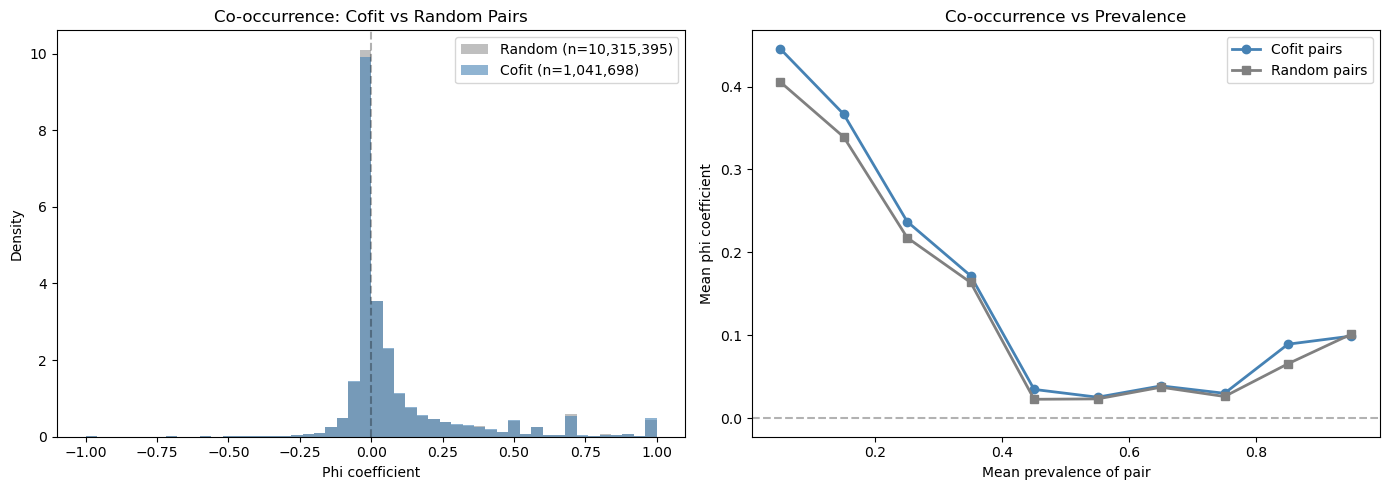

In [5]:
import matplotlib.pyplot as plt

if all_results:
    combined = pd.read_csv(DATA_DIR / 'all_phi_results.tsv', sep='\t',
                           dtype={'locusId1': str, 'locusId2': str})

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    cofit_phi = combined[combined['is_cofit']]['phi'].dropna()
    random_phi = combined[~combined['is_cofit']]['phi'].dropna()

    axes[0].hist(random_phi, bins=50, alpha=0.5, label=f'Random (n={len(random_phi):,})',
                 color='gray', density=True)
    axes[0].hist(cofit_phi, bins=50, alpha=0.6, label=f'Cofit (n={len(cofit_phi):,})',
                 color='steelblue', density=True)
    axes[0].set_xlabel('Phi coefficient')
    axes[0].set_ylabel('Density')
    axes[0].set_title('Co-occurrence: Cofit vs Random Pairs')
    axes[0].legend()
    axes[0].axvline(0, color='black', linestyle='--', alpha=0.3)

    bins = np.arange(0, 1.05, 0.1)
    combined['prev_bin'] = pd.cut(combined['mean_prev'], bins=bins, labels=False)
    combined['prev_bin_center'] = combined['prev_bin'] * 0.1 + 0.05

    cofit_by_bin = combined[combined['is_cofit']].groupby('prev_bin_center')['phi'].mean()
    random_by_bin = combined[~combined['is_cofit']].groupby('prev_bin_center')['phi'].mean()

    axes[1].plot(cofit_by_bin.index, cofit_by_bin.values, 'o-', color='steelblue',
                 label='Cofit pairs', linewidth=2, markersize=6)
    axes[1].plot(random_by_bin.index, random_by_bin.values, 's-', color='gray',
                 label='Random pairs', linewidth=2, markersize=6)
    axes[1].set_xlabel('Mean prevalence of pair')
    axes[1].set_ylabel('Mean phi coefficient')
    axes[1].set_title('Co-occurrence vs Prevalence')
    axes[1].legend()
    axes[1].axhline(0, color='black', linestyle='--', alpha=0.3)

    plt.tight_layout()
    plt.savefig('../figures/quick_cooccurrence.png', dpi=150, bbox_inches='tight')
    plt.show()

In [6]:
print('=' * 60)
print('NB02 SUMMARY: Co-occurrence Analysis')
print('=' * 60)
if all_results:
    combined = pd.read_csv(DATA_DIR / 'all_phi_results.tsv', sep='\t',
                           dtype={'locusId1': str, 'locusId2': str})
    cofit = combined[combined['is_cofit']]
    rand = combined[~combined['is_cofit']]
    print(f'Organisms analyzed: {combined["orgId"].nunique()}')
    print(f'Cofit pairs: {len(cofit):,}')
    print(f'Random pairs: {len(rand):,}')
    print(f'Mean phi (cofit): {cofit["phi"].mean():.4f}')
    print(f'Mean phi (random): {rand["phi"].mean():.4f}')
    print(f'Delta: {cofit["phi"].mean() - rand["phi"].mean():.4f}')
    u, p = stats.mannwhitneyu(
        cofit['phi'].dropna(), rand['phi'].dropna(), alternative='two-sided'
    )
    print(f'Overall Mann-Whitney U (two-sided): p={p:.2e}')
else:
    print('No data -- run NB01 first')
print('=' * 60)

NB02 SUMMARY: Co-occurrence Analysis


Organisms analyzed: 9
Cofit pairs: 2,253,491
Random pairs: 22,534,910
Mean phi (cofit): 0.0918
Mean phi (random): 0.0886
Delta: 0.0032


Overall Mann-Whitney U (two-sided): p=1.66e-29
